<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

Мы имеем исторические данные о заказах такси в аэропортах.
Нам необходимо спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.


- Значение метрики **RMSE** на тестовой выборке должно быть не больше **48**
- Количество заказов находится в столбце **'num_orders' (от англ. number of orders, «число заказов»)**

# Подготовка

In [1]:
#импортируем нужные библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import os

!pip install plotly
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import plotly.express as px
import requests


#стат блок
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

!pip install prophet
from prophet import Prophet

#настройки
pd.set_option("display.max_rows", 10000)
pd.set_option('max_colwidth', 10000)
pd.set_option('display.width', 500)
pd.set_option("display.float_format", "{:,.2f}".format)
sns.set(style="whitegrid", palette="Pastel1")


import warnings
warnings.filterwarnings('ignore')


from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import (
                ElasticNet,
                Ridge,
                Lasso
)
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import (
                Pipeline, 
                make_pipeline
)

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import ( 
                TimeSeriesSplit,
                train_test_split,
                GridSearchCV,
                cross_val_score
)
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error
)


RANDOM_STATE = 42

C:\Users\390\anaconda3\envs\ds_practicum_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
try:
    taxi = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])
except FileNotFoundError:
    taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [3]:
#оставим копию на всякий случай
try:
    df = pd.read_csv('taxi.csv')
except FileNotFoundError:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [4]:
taxi.columns

Index(['num_orders'], dtype='object')

In [5]:
#функция для быстрого просмотра данных
def information(df: 'DataFrame', name: 'str') -> None:
    print('*'*30,name,'*'*30)
    print()
    display(df.head(3))
    print('-'*25,'INFO','-'*25)
    print()
    display(df.info())
    print()
    print('-'*10,'NAN','-'*10)
    print()
    display(df.isna().sum())
    display(pd.DataFrame(round(df.isna().mean()*100,1)).sort_values(by=0, ascending=False).style.background_gradient('coolwarm'))
    print()
    print('-'*5,'DESCRIBE','-'*5)
    display(df.describe())
    print()
    print('-'*5,'DUPLICATED','-'*5)
    display(df.duplicated().sum())
    print()
    print('-'*25,'UNIQUE VALUES','-'*25)
    for column in df.columns:
        display(column)
        display(len(df[column].unique()))
        print('+'*25)
    print("-"*100)

In [6]:
information(taxi, 'Такси')

****************************** Такси ******************************



num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28

------------------------- INFO -------------------------

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None


---------- NAN ----------



num_orders    0
dtype: int64


----- DESCRIBE -----


num_orders
count   26,496.00
mean        14.07
std          9.21
min          0.00
25%          8.00
50%         13.00
75%         19.00
max        119.00


----- DUPLICATED -----


26415


------------------------- UNIQUE VALUES -------------------------


'num_orders'

81

+++++++++++++++++++++++++
----------------------------------------------------------------------------------------------------


### Вывод:

Итак, данные выгружены:
- Выполнили чтение файла с разпознованием даты, дату поставили в индекс
- Мы имеем **26496** наблюдений
- В **datetime** имеем интервалы в **10 минут**
- Максимальное количество заказов **119** скорее всего выбросы, нужно исследовать наш таргет


# Анализ

Проверим, все ли индексы у нас уникальны.

In [7]:
print('Все индексы уникальны -', taxi.index.is_unique)

Все индексы уникальны - True


In [8]:
taxi.shape[0]

26496

Проверим последовательность индексов.

In [9]:
print('Индексы отсортированы в порядке возрастания -', taxi.index.is_monotonic)

Индексы отсортированы в порядке возрастания - True


In [10]:
#делаем ресэмплинг по 1 часу
taxi = taxi.resample('1H').sum()

In [11]:
taxi.shape[0]

4416

In [12]:
display(taxi.index.max())
display(taxi.index.min())

Timestamp('2018-08-31 23:00:00', freq='H')

Timestamp('2018-03-01 00:00:00', freq='H')

Наблюдения у нас с **1 марта 2018 года по 31 августа 2018 года**

In [13]:
taxi.index.max() - taxi.index.min()

Timedelta('183 days 23:00:00')

Всего **183** дня наблюдений, наблюдения производились с 00:00:00 по  23:00:00

**Посмотрим интерактивный график заказов по нашему датасету**

In [14]:
#функция для просмотра интерактивного графика по датасету
def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
    
%pylab inline    

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [15]:
plotly_df(taxi, title='Число заказов')

Посмотрим на распределение нашего таргета:

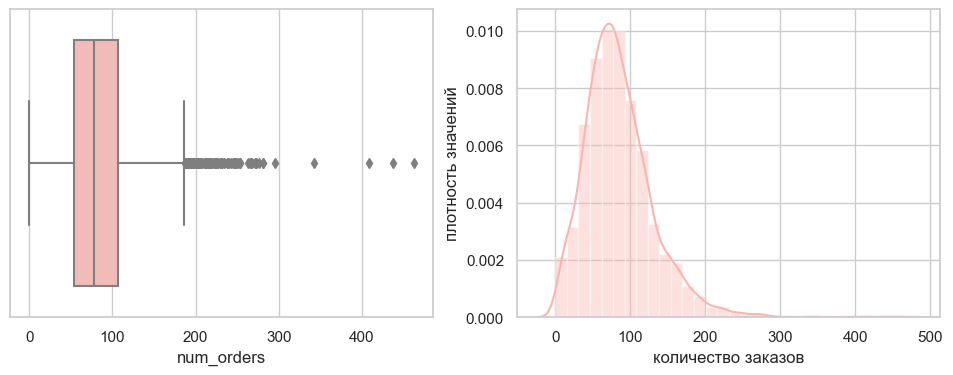

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
sns.boxplot(taxi['num_orders'], ax=axs[0])
sns.distplot(taxi['num_orders'], ax=axs[1], bins=30, rug=False)
plt.ylabel('плотность значений')
plt.xlabel('количество заказов');

In [17]:
taxi['num_orders'].quantile([0.0, 0.01, 0.02, 0.05, 0.1, 0.25, .5, .65, .75, .85, .93, .97, .99, 1]).transpose()

0.00     0.00
0.01     7.00
0.02    11.30
0.05    21.00
0.10    34.00
0.25    54.00
0.50    78.00
0.65    94.00
0.75   107.00
0.85   126.00
0.93   156.00
0.97   184.00
0.99   223.00
1.00   462.00
Name: num_orders, dtype: float64

По распределению значений можем наблюдать выбросы примерно после **184** заказов, но так как подробностей нам не узнать, будем исследовать данные. Видим, что частота значений начиная от **184** и заканчивая **290** заказами имеет плюс минус плотное распределение. Посмторим на цифры выше **300** особенно даты в эти заказы.

In [18]:
taxi.query('num_orders >=300')

num_orders
datetime                       
2018-08-13 02:00:00         437
2018-08-20 02:00:00         462
2018-08-27 02:00:00         408
2018-08-30 17:00:00         342

Интересно, что выбросы свыше **300** заказов были в основном в августе по понедельникам в **02:00**, вероятнее всего возвращающиеся с отпусков, так как в ночь с вскр на пнд, и один из дней четверг **30 августа** в час пик в **17:00**  это скорее всего суматоха родителей перед началом учебного года у школьников. Исходя иза этих данных можно сделать выводы, какие признаки создавать для модели: можно взять **день недели** и **время суток**

### Посмотрим на общую картину нашего временного ряда

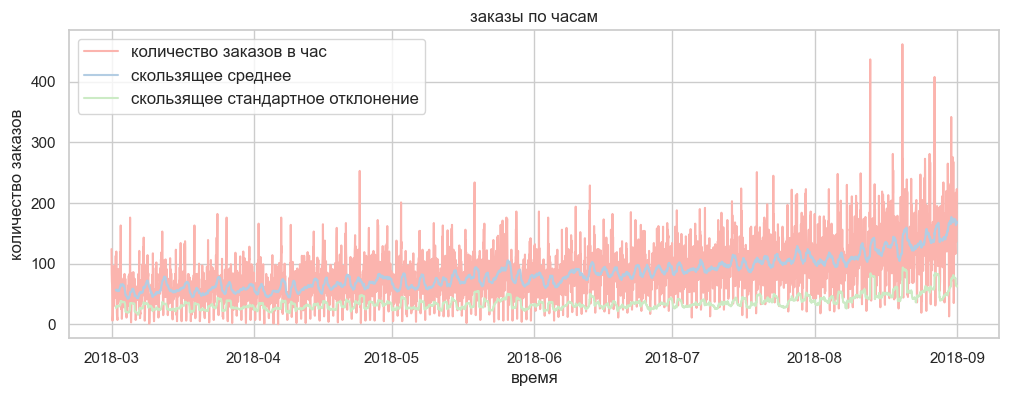

In [19]:
# построим график временного ряда
plt.figure(figsize=(12, 4))
plt.plot(taxi, label = 'количество заказов в час')
plt.plot(taxi.rolling(24).mean(), label = 'скользящее среднее')
plt.plot(taxi.rolling(24).std(), label = 'скользящее стандартное отклонение')

plt.legend(title='', loc='upper left', fontsize=12)
plt.xlabel('время')
plt.ylabel('количество заказов')
plt.title('заказы по часам')
plt.show;

- Как видим тренд на повышение идет с начала **апреля** и до конца наблюдений
- Видны переодичные всплески по месяцам, можно увидеть что в конце **апреля** есть большой всплеск, в **мае**, а также большее количество всплесков наблюдаем в **августе**

### Визуализируем данные по составляющим. Проанализируем их по последнему месяцу наблюдений - август 2018.

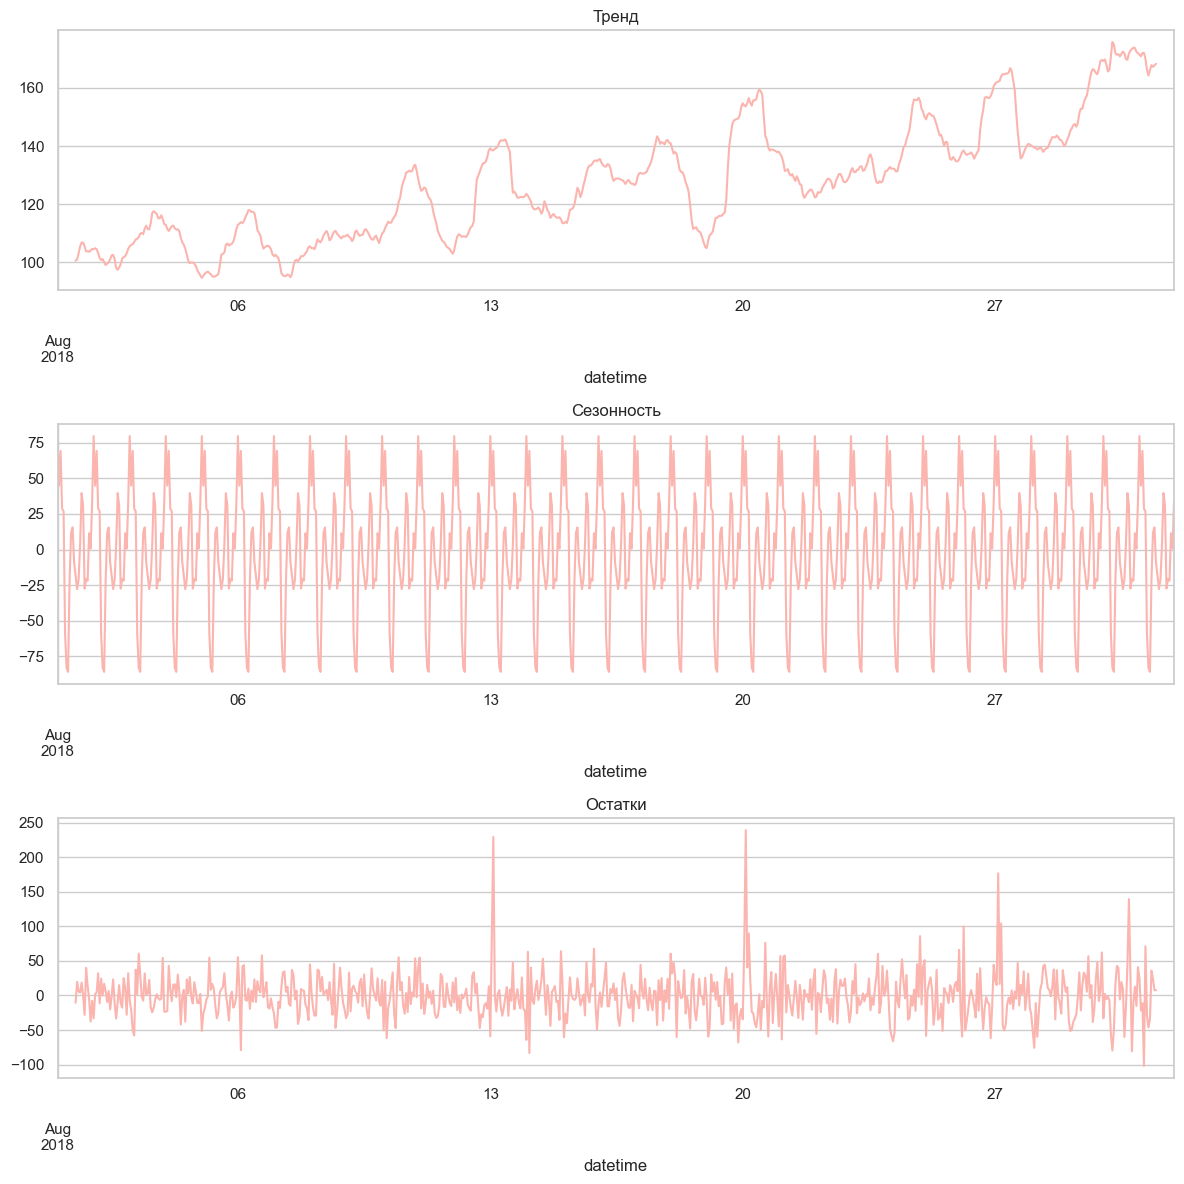

In [20]:
decomposed = seasonal_decompose(taxi['2018-08-01':'2018-08-31'])
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Остатки')
plt.tight_layout()

- Тренд имеет рост на протяжении всего месяца, очень хорошо видно наши пики - **13, 20, 27 и 30 августа**
- Чтобы понять как влияет сезонность нужно сделать визуализацию автокорреляции
- Остатки тоже имеют переодические всплески как раз в те же дни что и у тренда

### Посмотрим на сезонность и тренд по всему датасету 

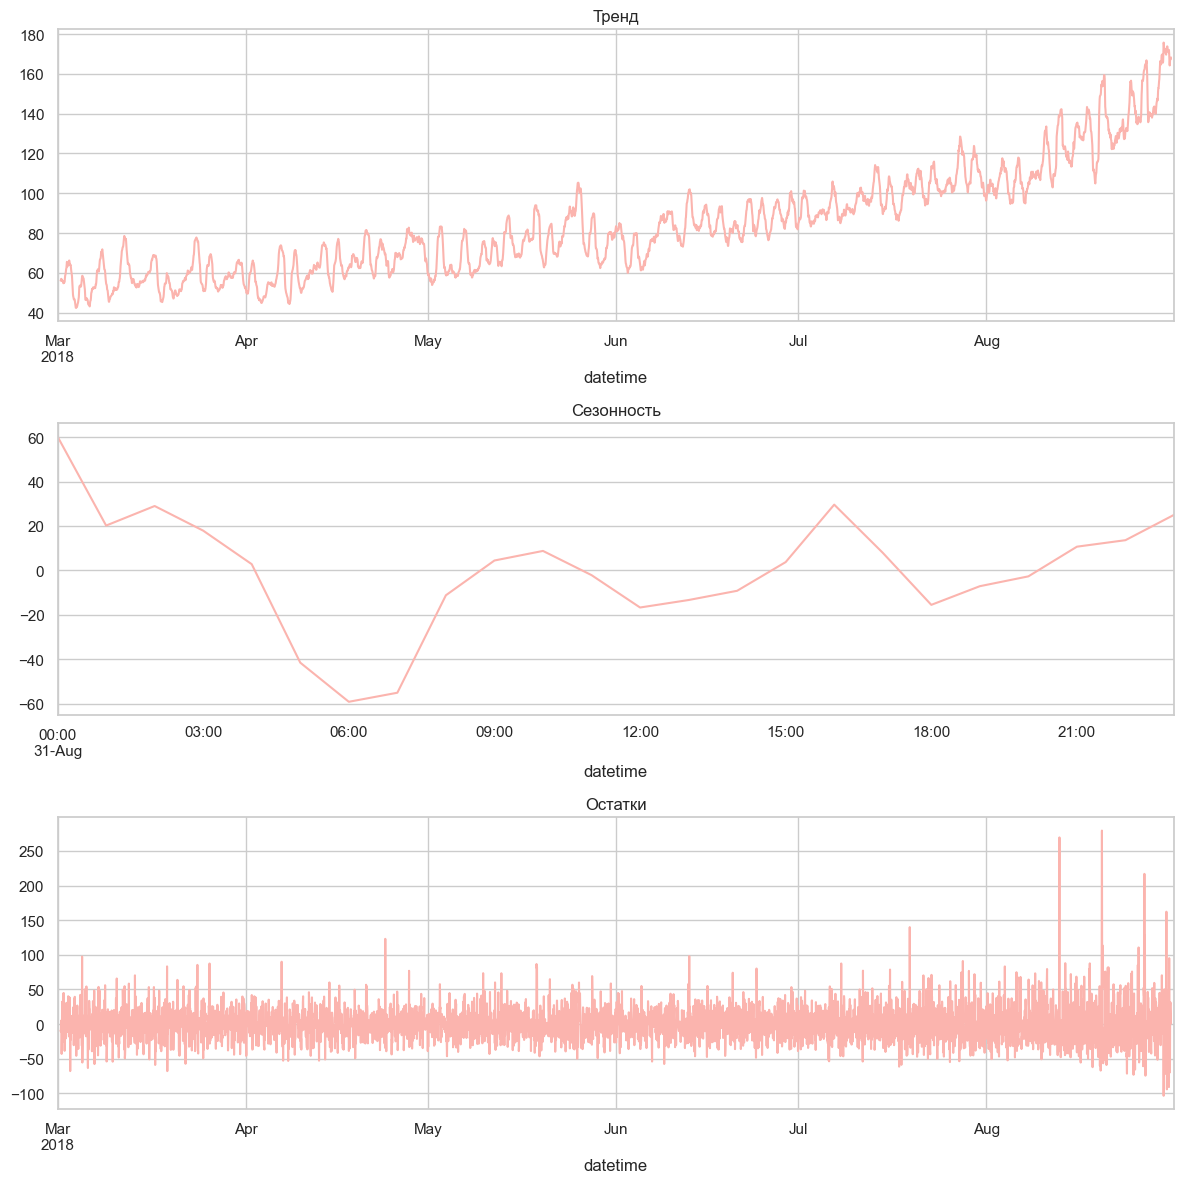

In [21]:
decomposed = seasonal_decompose(taxi)
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)

#посмотрим на дневную сезонность
decomposed.seasonal.tail(24).plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Остатки')
plt.tight_layout()

### Проведем стат тест **Dickey-Fuller** (Дики-Фуллера) на стационарность ряда и визуализируем наши данные в автокорреляции по часам

**Сформулируем гипотезы:**

- **H0:** Временной ряд является нестационарным. Другими словами, он имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени.

- **H1:** Временной ряд является стационарным.

- Установим **α = 0.01 (1%)**



Критерий Дики-Фуллера: p=0.028940
H0 подтвердилась, временной ряд имеет единичные корни, ряд не стационарен


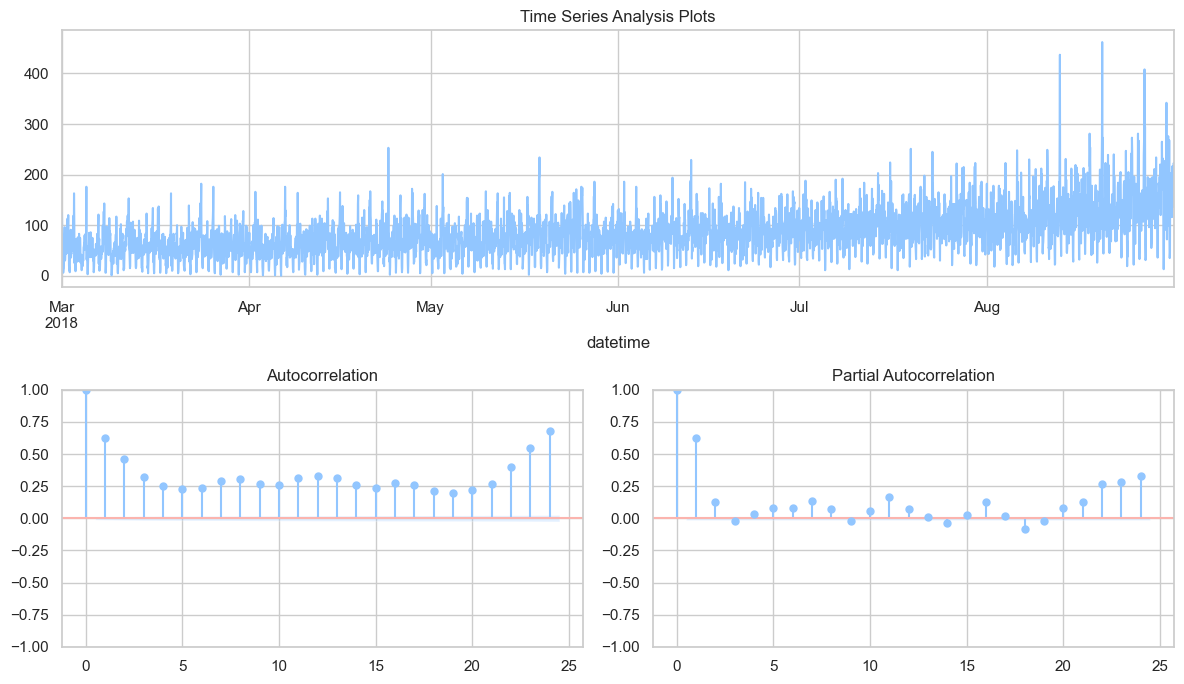

In [22]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context("seaborn-pastel"):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        
        α = 0.01

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        if sm.tsa.stattools.adfuller(y)[1] > 0.01:
            print("H0 подтвердилась, временной ряд имеет единичные корни, ряд не стационарен")
        else:
            print("отвергаем H0, временной ряд не имеет единичных корней , ряд стационарен") 

        plt.tight_layout()
    return 

tsplot(taxi['num_orders'], lags=24)

Как мы можем наблюдать, при установке значимости **α = 0.01 (1%)** у нас ряд **не стационарен**, однако, если установить уровень значимости **α = 0.05 (5%)** ряд будет **стационарным**.

Но так как мы всегда полагаемся на данные и наши исследования (мы наблюдаем рост заказов в тренде, причем зависимость не линейная а скорее квадратичная, плюс наблюдается наличие сезонности, отчетливо видна **дневная** сезонность), устанавливаем значение **α** строже, так как понимая нашу задачу прогнозирования заказов, этот фактор имеет очень важную составляющую. Прогнозировать на нестационарном ряду сложнее, чем на стационарном. Иначе говоря, нам предстоит строить прогнозирование сравнивая исходный датасет. 

По графику автокорреляции можем наблюдать пики начиная с **00:00 часов и заканчивая 3 часами ночи**, далее **с 22 часов и до 00:00** так же.


In [23]:
taxi.shape[0]

4416

### Создадим признаки с помощью Prophet

In [24]:
predictions = 24*4

train_df = taxi[:-predictions]
train_df.reset_index(inplace=True)
train_df.columns = ['ds', 'y']
taxi.columns = ['y']
train_df.tail()

# Python
m = Prophet(changepoint_prior_scale=0.10, seasonality_prior_scale=10.00, holidays_prior_scale=0.01,
            seasonality_mode= 'additive')
m.fit(train_df);

future = m.make_future_dataframe(periods=predictions, freq='1H')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

10:53:05 - cmdstanpy - INFO - Chain [1] start processing
10:53:05 - cmdstanpy - INFO - Chain [1] done processing


ds   yhat  yhat_lower  yhat_upper
4411 2018-08-31 19:00:00 141.85      106.70      174.38
4412 2018-08-31 20:00:00 148.66      116.89      184.74
4413 2018-08-31 21:00:00 163.98      130.05      197.89
4414 2018-08-31 22:00:00 177.79      142.52      211.86
4415 2018-08-31 23:00:00 185.04      153.00      218.02

In [25]:
forecast.shape[0]

4416

In [26]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, daily, daily_lower, daily_upper, weekly, weekly_lower, weekly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


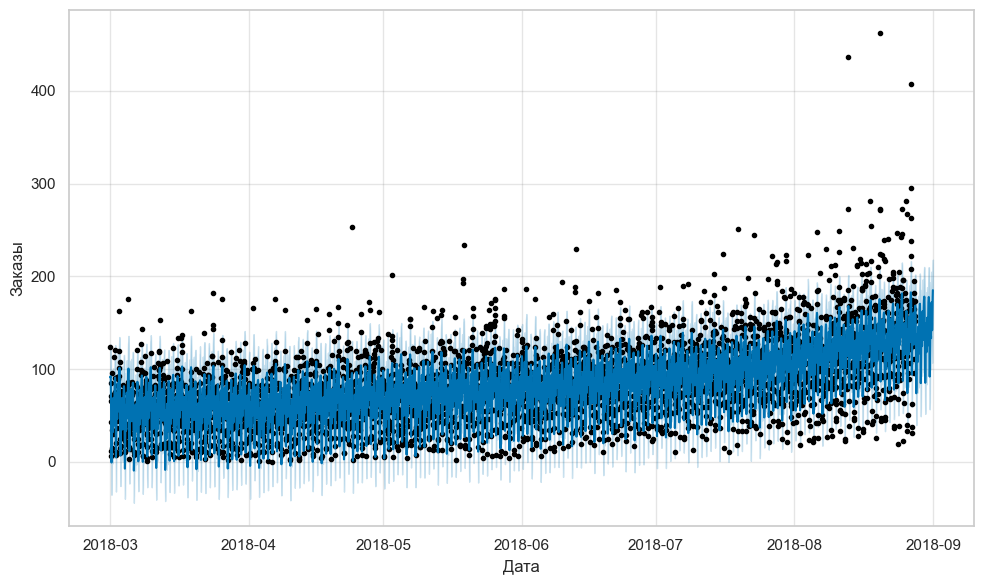

In [27]:
m.plot(forecast)
plt.xlabel('Дата')
plt.ylabel('Заказы');

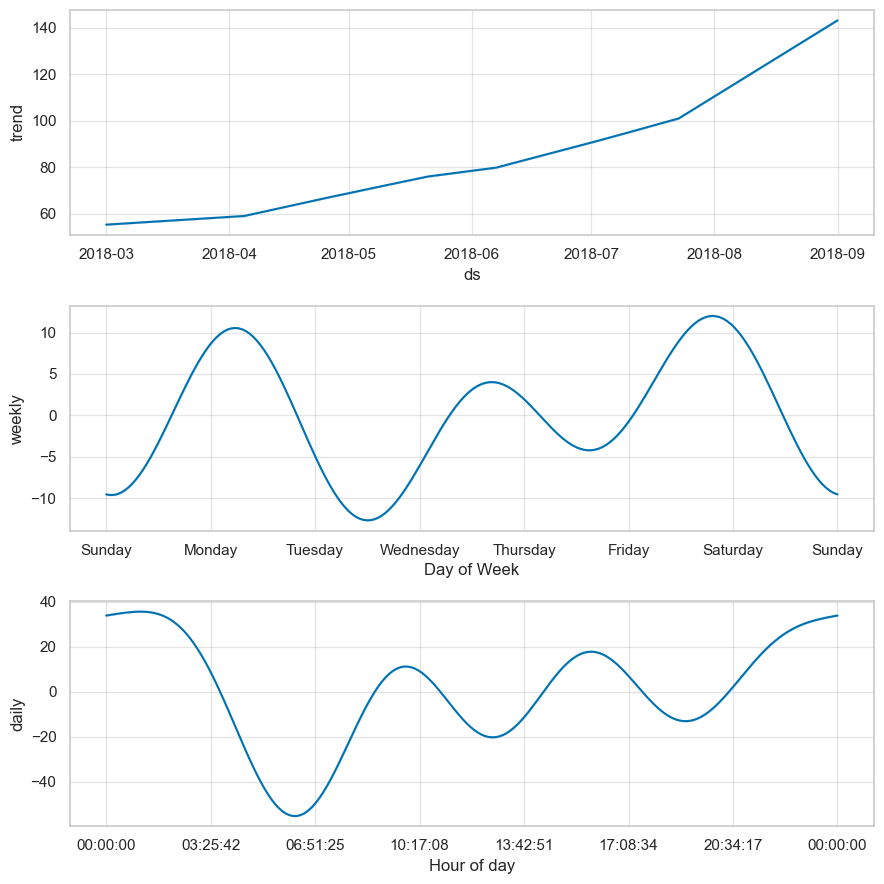

In [28]:
m.plot_components(forecast);

**Посмотрим на интерактивный график прогноза заказов**

In [29]:
cmp_df = forecast.set_index('ds')[['yhat', 'trend','additive_terms', 'yhat_lower', 'yhat_upper', 'trend_lower',
                                   'trend_upper',  'additive_terms', 'additive_terms_lower',
                                   'additive_terms_upper', 'daily', 'weekly']].join(taxi)

In [30]:
#функция для визуализации построенного прогноза
def show_forecast(df, num_predictions, num_values):
    #верхняя граница доверительного интервала прогноза
    upper_bound = go.Scatter(
        name='Upper Bound',
        x=df.tail(num_predictions).index,
        y=df.tail(num_predictions).yhat_upper,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')

    #прогноз
    forecast = go.Scatter(
        name='Prediction',
        x=df.tail(predictions).index,
        y=df.tail(predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )

    #нижняя граница доверительного интервала
    lower_bound = go.Scatter(
        name='Lower Bound',
        x=df.tail(num_predictions).index,
        y=df.tail(num_predictions).yhat_lower,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines')

    #фактические значения
    fact = go.Scatter(
        name='Fact',
        x=df.tail(num_values).index,
        y=df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )

    #последовательность рядов в данном случае важна из-за применения заливки
    data = [lower_bound, upper_bound, forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='Количество заказов'),
        title='Заказы такси: прогноз',
        showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(round(cmp_df), predictions, 200)

**Мы можем наблюдать что переломные пики предсказать очень трудно**

In [31]:
cmp_df.isna().sum()

yhat                    0
trend                   0
additive_terms          0
yhat_lower              0
yhat_upper              0
trend_lower             0
trend_upper             0
additive_terms          0
additive_terms_lower    0
additive_terms_upper    0
daily                   0
weekly                  0
y                       0
dtype: int64

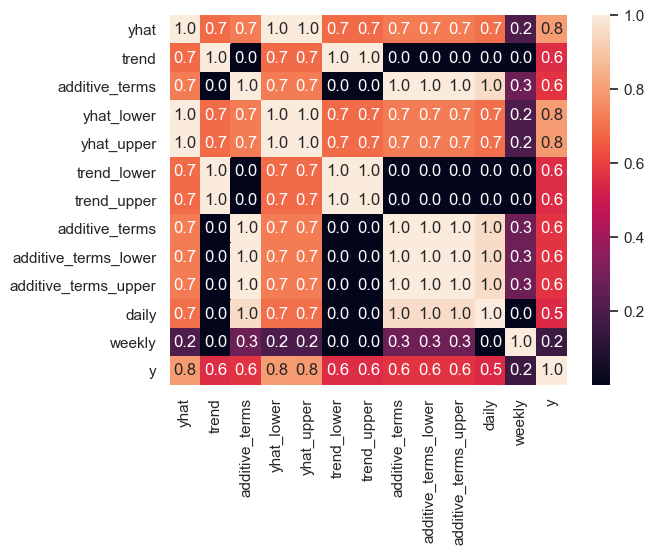

In [32]:
sns.heatmap(data=cmp_df.corr(), annot=True, fmt='.1f');

# Обучение

In [33]:
train, test = train_test_split(cmp_df, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)
train = train.dropna()
test = test.dropna()
X_train = train.drop(['y'], axis=1)
X_test = test.drop(['y'], axis=1)
y_train = train['y']
y_test = test['y']
print(f"  Train: size={train.shape[0]}")
print(f"  Test:  size={test.shape[0]}")

  Train: size=3974
  Test:  size=442


In [34]:
X_train

yhat  trend  additive_terms  yhat_lower  yhat_upper  trend_lower  trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  daily  weekly
ds                                                                                                                                                                            
2018-03-01 00:00:00  91.07  55.22           35.85       56.24      124.01        55.22        55.22           35.85                 35.85                 35.85  33.91    1.94
2018-03-01 01:00:00  92.26  55.22           37.04       59.40      126.51        55.22        55.22           37.04                 37.04                 37.04  35.61    1.43
2018-03-01 02:00:00  89.06  55.23           33.84       53.79      121.49        55.23        55.23           33.84                 33.84                 33.84  32.95    0.89
2018-03-01 03:00:00  74.58  55.23           19.35       41.59      108.91        55.23        55.23           19.35                 19.35                 19.35  19.02    0.33
2018-03-01 04:00:00  47.02  55.24           -8.22       12.37       80.85        55.24        55.24           -8.22                 -8.22                 -8.22  -7.98   -0.24
2018-03-01 05:00:00  16.22  55.24          -39.02      -16.34       52.39        55.24        55.24          -39.02                -39.02                -39.02 -38.21   -0.81
2018-03-01 06:00:00  -0.89  55.25          -56.14      -35.61       33.95        55.25        55.25          -56.14                -56.14                -56.14 -54.78   -1.36
2018-03-01 07:00:00   6.21  55.25          -49.04      -28.65       38.91        55.25        55.25          -49.04                -49.04                -49.04 -47.15   -1.89
2018-03-01 08:00:00  31.56  55.25          -23.70       -1.39       62.65        55.25        55.25          -23.70                -23.70                -23.70 -21.31   -2.39
2018-03-01 09:00:00  56.11  55.26            0.85       23.75       91.00        55.26        55.26            0.85                  0.85                  0.85   3.69   -2.84
2018-03-01 10:00:00  62.98  55.26            7.72       29.15       98.51        55.26        55.26            7.72                  7.72                  7.72  10.96   -3.24
2018-03-01 11:00:00  51.15  55.27           -4.11       14.82       83.54        55.27        55.27           -4.11                 -4.11                 -4.11  -0.53   -3.59
2018-03-01 12:00:00  35.27  55.27          -20.00        0.18       66.79        55.27        55.27          -20.00                -20.00                -20.00 -16.14   -3.86
2018-03-01 13:00:00  31.87  55.28          -23.40       -1.70       66.41        55.28        55.28          -23.40                -23.40                -23.40 -19.34   -4.07
2018-03-01 14:00:00  44.63  55.28          -10.65       10.88       78.96        55.28        55.28          -10.65                -10.65                -10.65  -6.46   -4.19
2018-03-01 15:00:00  62.04  55.28            6.76       29.02       94.44        55.28        55.28            6.76                  6.76                  6.76  10.99   -4.23
2018-03-01 16:00:00  68.89  55.29           13.60       35.59      100.82        55.29        55.29           13.60                 13.60                 13.60  17.79   -4.19
2018-03-01 17:00:00  60.35  55.29            5.06       28.73       92.17        55.29        55.29            5.06                  5.06                  5.06   9.11   -4.06
2018-03-01 18:00:00  45.63  55.30           -9.67       13.11       77.46        55.30        55.30           -9.67                 -9.67                 -9.67  -5.83   -3.84
2018-03-01 19:00:00  38.72  55.30          -16.58        3.86       72.15        55.30        55.30          -16.58                -16.58                -16.58 -13.05   -3.53
2018-03-01 20:00:00  45.90  55.31           -9.40       13.40       80.18        55.31        55.31           -9.40                 -9.40                 -9.40  -6.27   -3.

In [35]:
X_test

yhat  trend  additive_terms  yhat_lower  yhat_upper  trend_lower  trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  daily  weekly
ds                                                                                                                                                                            
2018-08-13 14:00:00 123.62 123.67           -0.04       90.56      157.32       123.67       123.67           -0.04                 -0.04                 -0.04  -6.46    6.41
2018-08-13 15:00:00 140.14 123.71           16.43      105.43      174.97       123.71       123.71           16.43                 16.43                 16.43  10.99    5.44
2018-08-13 16:00:00 145.95 123.75           22.19      113.84      179.54       123.75       123.75           22.19                 22.19                 22.19  17.79    4.41
2018-08-13 17:00:00 136.22 123.80           12.42      102.34      172.17       123.80       123.80           12.42                 12.42                 12.42   9.11    3.31
2018-08-13 18:00:00 120.18 123.84           -3.66       85.88      154.09       123.84       123.84           -3.66                 -3.66                 -3.66  -5.83    2.17
2018-08-13 19:00:00 111.83 123.89          -12.06       75.16      146.77       123.89       123.89          -12.06                -12.06                -12.06 -13.05    0.99
2018-08-13 20:00:00 117.45 123.93           -6.48       82.49      149.75       123.93       123.93           -6.48                 -6.48                 -6.48  -6.27   -0.21
2018-08-13 21:00:00 131.70 123.97            7.73       98.68      164.94       123.97       123.97            7.73                  7.73                  7.73   9.14   -1.41
2018-08-13 22:00:00 144.56 124.02           20.54      110.49      178.84       124.02       124.02           20.54                 20.54                 20.54  23.15   -2.61
2018-08-13 23:00:00 150.98 124.06           26.92      118.13      186.30       124.06       124.06           26.92                 26.92                 26.92  30.71   -3.80
2018-08-14 00:00:00 153.06 124.11           28.96      118.80      183.53       124.11       124.11           28.96                 28.96                 28.96  33.91   -4.95
2018-08-14 01:00:00 153.70 124.15           29.55      121.09      186.75       124.15       124.15           29.55                 29.55                 29.55  35.61   -6.06
2018-08-14 02:00:00 150.03 124.19           25.84      118.19      185.24       124.19       124.19           25.84                 25.84                 25.84  32.95   -7.11
2018-08-14 03:00:00 135.16 124.24           10.92      102.60      169.54       124.24       124.24           10.92                 10.92                 10.92  19.02   -8.10
2018-08-14 04:00:00 107.29 124.28          -16.99       73.09      142.91       124.28       124.28          -16.99                -16.99                -16.99  -7.98   -9.01
2018-08-14 05:00:00  76.28 124.33          -48.05       41.03      112.28       124.33       124.33          -48.05                -48.05                -48.05 -38.21   -9.84
2018-08-14 06:00:00  59.02 124.37          -65.35       26.84       89.74       124.37       124.37          -65.35                -65.35                -65.35 -54.78  -10.57
2018-08-14 07:00:00  66.06 124.41          -58.35       32.06      100.13       124.41       124.41          -58.35                -58.35                -58.35 -47.15  -11.20
2018-08-14 08:00:00  91.42 124.46          -33.04       56.67      128.62       124.46       124.46          -33.04                -33.04                -33.04 -21.31  -11.73
2018-08-14 09:00:00 116.05 124.50           -8.45       82.31      148.99       124.50       124.50           -8.45                 -8.45                 -8.45   3.69  -12.14
2018-08-14 10:00:00 123.07 124.55           -1.48       87.41      157.91       124.55       124.55           -1.48                 -1.48                 -1.48  10.96  -12.

In [36]:
pipeline = Pipeline(steps=[('scaler', RobustScaler())])
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [37]:
split = TimeSeriesSplit(n_splits=3)

In [38]:
#функция для кросс валидации (подбора модели без гиперпараметров)
def cross_val(model):
    cvs = cross_val_score(model, X_train, y_train, cv=split,
                          scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
    return print("Лучшее значение",  model,  "на кросс валидации:", -cvs)

In [39]:
cross_val(Lasso(random_state=RANDOM_STATE))

Лучшее значение Lasso(random_state=42) на кросс валидации: 27.020015028171787


In [40]:
cross_val(ElasticNet(random_state=RANDOM_STATE))

Лучшее значение ElasticNet(random_state=42) на кросс валидации: 28.88324623641221


In [41]:
cross_val(Ridge(random_state=RANDOM_STATE))

Лучшее значение Ridge(random_state=42) на кросс валидации: 25.873891400530052


In [42]:
cross_val(LGBMRegressor(random_state=RANDOM_STATE))

Лучшее значение LGBMRegressor(random_state=42) на кросс валидации: 25.546062312842167


In [43]:
cross_val(CatBoostRegressor(random_state=RANDOM_STATE))

Лучшее значение <catboost.core.CatBoostRegressor object at 0x000002AE54E5DF40> на кросс валидации: 25.386125493421247


**По итогам кросс валидации у нас лидируют Ridge, LGBM и CatBoost**

In [44]:
%%time
rg = Pipeline(steps=[('regressor', Ridge(random_state=RANDOM_STATE))])


#задаем параметры для grid search
param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1]
}

#создаем объект GridSearchCV
s_rg = GridSearchCV(rg, param_grid=param_grid, cv=split,
                      scoring='neg_root_mean_squared_error',
                      refit=True, error_score='raise', n_jobs=-1)

#обучаем модель на тренировочных данных
s_rg.fit(X_train, y_train)

#выводим лучшие параметры и результаты кросс-валидации
print("Лучшие параметры: ", s_rg.best_params_)
print("Лучшее значение: ", -s_rg.best_score_)

Лучшие параметры:  {'regressor__alpha': 1}
Лучшее значение:  25.873891400530052
CPU times: total: 93.8 ms
Wall time: 89.2 ms


In [45]:
%%time
lgbm = Pipeline(steps=[('regressor', LGBMRegressor(random_state=RANDOM_STATE))])


#задаем параметры для grid search
param_grid = {
    'regressor__learning_rate': [0.1, 0.2],
    'regressor__n_estimators' : range(100, 400, 50),
    'regressor__max_depth' : range(10, 16 , 5),
}

#создаем объект GridSearchCV
s_lgbm = GridSearchCV(lgbm, param_grid=param_grid, cv=split,
                      scoring='neg_root_mean_squared_error',
                      refit=True, error_score='raise', n_jobs=-1)

#обучаем модель на тренировочных данных
s_lgbm.fit(X_train, y_train)

#выводим лучшие параметры и результаты кросс-валидации
print("Лучшие параметры: ", s_lgbm.best_params_)
print("Лучшее значение: ", -s_lgbm.best_score_)

Лучшие параметры:  {'regressor__learning_rate': 0.1, 'regressor__max_depth': 15, 'regressor__n_estimators': 150}
Лучшее значение:  25.505377905343224
CPU times: total: 1.98 s
Wall time: 8.36 s


In [46]:
%%time
cb = Pipeline(steps=[('regressor', CatBoostRegressor(random_state=RANDOM_STATE))])
param_grid = {
    'regressor__learning_rate': [0.1, 0.3, 0.01],
    'regressor__n_estimators': range(100, 301, 100),
}

#создаем объект GridSearchCV
s_cb = GridSearchCV(cb, param_grid=param_grid, cv=split,
                    scoring='neg_root_mean_squared_error', refit=True, error_score='raise', n_jobs=-1)

#обучаем модель на тренировочных данных
s_cb.fit(X_train, y_train)

#выводим лучшие параметры и результаты кросс-валидации
print("Лучшие параметры: ", s_cb.best_params_)
print("Лучшее значение: ", -s_cb.best_score_)

0:	learn: 36.5850219	total: 146ms	remaining: 29s
1:	learn: 34.8058353	total: 149ms	remaining: 14.8s
2:	learn: 33.1720712	total: 152ms	remaining: 9.99s
3:	learn: 31.8123107	total: 155ms	remaining: 7.62s
4:	learn: 30.6833926	total: 159ms	remaining: 6.19s
5:	learn: 29.6015276	total: 162ms	remaining: 5.22s
6:	learn: 28.6697389	total: 165ms	remaining: 4.54s
7:	learn: 27.8980947	total: 168ms	remaining: 4.02s
8:	learn: 27.2263968	total: 171ms	remaining: 3.62s
9:	learn: 26.6639678	total: 174ms	remaining: 3.3s
10:	learn: 26.2126802	total: 177ms	remaining: 3.04s
11:	learn: 25.7945869	total: 180ms	remaining: 2.82s
12:	learn: 25.4462758	total: 183ms	remaining: 2.63s
13:	learn: 25.1509022	total: 186ms	remaining: 2.48s
14:	learn: 24.8762181	total: 190ms	remaining: 2.34s
15:	learn: 24.5754272	total: 194ms	remaining: 2.23s
16:	learn: 24.3163434	total: 197ms	remaining: 2.12s
17:	learn: 24.1609272	total: 200ms	remaining: 2.02s
18:	learn: 23.8750987	total: 204ms	remaining: 1.94s
19:	learn: 23.7453207	tot

174:	learn: 17.9734773	total: 750ms	remaining: 107ms
175:	learn: 17.9615965	total: 753ms	remaining: 103ms
176:	learn: 17.9423944	total: 757ms	remaining: 98.3ms
177:	learn: 17.9214448	total: 760ms	remaining: 93.9ms
178:	learn: 17.9077908	total: 763ms	remaining: 89.5ms
179:	learn: 17.8842071	total: 767ms	remaining: 85.2ms
180:	learn: 17.8680152	total: 770ms	remaining: 80.8ms
181:	learn: 17.8411176	total: 773ms	remaining: 76.4ms
182:	learn: 17.8363549	total: 776ms	remaining: 72.1ms
183:	learn: 17.8252969	total: 779ms	remaining: 67.7ms
184:	learn: 17.8089906	total: 782ms	remaining: 63.4ms
185:	learn: 17.7958500	total: 786ms	remaining: 59.2ms
186:	learn: 17.7814347	total: 789ms	remaining: 54.9ms
187:	learn: 17.7523930	total: 792ms	remaining: 50.6ms
188:	learn: 17.7298439	total: 796ms	remaining: 46.3ms
189:	learn: 17.6979592	total: 799ms	remaining: 42ms
190:	learn: 17.6780481	total: 802ms	remaining: 37.8ms
191:	learn: 17.6492522	total: 805ms	remaining: 33.5ms
192:	learn: 17.6318311	total: 80

**Так как все три модели показывают впринципе неплохой результат, я склоняюсь сделать bagging для двух моделей-Ridge(линейная) так как мы знаем, что линейные модели хорошо экстраполируют, чтобы строить прогноз не только на ближайший час, а видеть тренды, по месяцам..., и CatBoost так как у этой модели вшиты хорошие параметры для предотвращения переобучения**

In [47]:
#создаем базовые модели
catboost = s_cb.best_estimator_
ridge = s_rg.best_estimator_

#создаем бэггинг-модель, используя базовые модели
bagging = BaggingRegressor(base_estimator=catboost, n_estimators=6, random_state=RANDOM_STATE)

pipeline = Pipeline([('bagging', bagging)
])


param_grid = { }

#создаем объект GridSearchCV
search_bagging = GridSearchCV(pipeline, param_grid=param_grid, cv=split,
                              scoring='neg_root_mean_squared_error', n_jobs=-1, refit=True)

#обучаем модель на тренировочных данных
search_bagging.fit(X_train, y_train)

#выводим результаты кросс-валидации
print("Best cross-validation score: ", -search_bagging.best_score_)


0:	learn: 36.7254081	total: 3.31ms	remaining: 658ms
1:	learn: 34.8913438	total: 6.49ms	remaining: 642ms
2:	learn: 33.2154430	total: 9.42ms	remaining: 619ms
3:	learn: 31.7939849	total: 12.5ms	remaining: 610ms
4:	learn: 30.5774247	total: 15.3ms	remaining: 598ms
5:	learn: 29.5313789	total: 18.2ms	remaining: 590ms
6:	learn: 28.6035867	total: 21ms	remaining: 580ms
7:	learn: 27.8154638	total: 23.8ms	remaining: 571ms
8:	learn: 27.1205127	total: 26.7ms	remaining: 567ms
9:	learn: 26.5218276	total: 29.6ms	remaining: 562ms
10:	learn: 26.0477684	total: 32.6ms	remaining: 560ms
11:	learn: 25.6309414	total: 35.9ms	remaining: 563ms
12:	learn: 25.2428566	total: 38.9ms	remaining: 560ms
13:	learn: 24.9260680	total: 41.8ms	remaining: 555ms
14:	learn: 24.6122578	total: 44.7ms	remaining: 552ms
15:	learn: 24.3130671	total: 47.5ms	remaining: 547ms
16:	learn: 24.0900681	total: 50.4ms	remaining: 543ms
17:	learn: 23.8068662	total: 53.4ms	remaining: 539ms
18:	learn: 23.5876291	total: 56.2ms	remaining: 535ms
19:	l

0:	learn: 37.1180673	total: 3.25ms	remaining: 647ms
1:	learn: 35.3539401	total: 6.49ms	remaining: 643ms
2:	learn: 33.7151080	total: 9.59ms	remaining: 630ms
3:	learn: 32.3247127	total: 12.6ms	remaining: 618ms
4:	learn: 31.1207075	total: 15.6ms	remaining: 610ms
5:	learn: 30.1055047	total: 18.5ms	remaining: 598ms
6:	learn: 29.1950199	total: 21.2ms	remaining: 586ms
7:	learn: 28.4056894	total: 24.1ms	remaining: 579ms
8:	learn: 27.7482532	total: 27ms	remaining: 573ms
9:	learn: 27.2255347	total: 30.1ms	remaining: 571ms
10:	learn: 26.7751165	total: 33ms	remaining: 567ms
11:	learn: 26.3235414	total: 35.9ms	remaining: 562ms
12:	learn: 25.9736934	total: 38.7ms	remaining: 557ms
13:	learn: 25.6291456	total: 41.7ms	remaining: 554ms
14:	learn: 25.3444331	total: 44.7ms	remaining: 552ms
15:	learn: 25.0669444	total: 47.7ms	remaining: 548ms
16:	learn: 24.8634256	total: 50.7ms	remaining: 546ms
17:	learn: 24.6628568	total: 53.7ms	remaining: 543ms
18:	learn: 24.3563869	total: 56.7ms	remaining: 540ms
19:	lea

191:	learn: 16.7585453	total: 590ms	remaining: 24.6ms
192:	learn: 16.7418650	total: 594ms	remaining: 21.5ms
193:	learn: 16.7097576	total: 597ms	remaining: 18.5ms
194:	learn: 16.6802240	total: 600ms	remaining: 15.4ms
195:	learn: 16.6637740	total: 603ms	remaining: 12.3ms
196:	learn: 16.6439345	total: 606ms	remaining: 9.22ms
197:	learn: 16.6194567	total: 609ms	remaining: 6.15ms
198:	learn: 16.5877578	total: 612ms	remaining: 3.08ms
199:	learn: 16.5632091	total: 615ms	remaining: 0us
0:	learn: 37.7869273	total: 3.4ms	remaining: 677ms
1:	learn: 35.8814900	total: 6.45ms	remaining: 639ms
2:	learn: 34.1349008	total: 9.52ms	remaining: 625ms
3:	learn: 32.7086226	total: 12.6ms	remaining: 617ms
4:	learn: 31.4577142	total: 15.6ms	remaining: 609ms
5:	learn: 30.3762183	total: 18.7ms	remaining: 604ms
6:	learn: 29.4857900	total: 21.7ms	remaining: 598ms
7:	learn: 28.6828095	total: 24.7ms	remaining: 592ms
8:	learn: 27.9701023	total: 27.7ms	remaining: 587ms
9:	learn: 27.3293380	total: 30.8ms	remaining: 584m

172:	learn: 17.0795721	total: 534ms	remaining: 83.3ms
173:	learn: 17.0574490	total: 537ms	remaining: 80.3ms
174:	learn: 17.0222552	total: 540ms	remaining: 77.2ms
175:	learn: 16.9930636	total: 543ms	remaining: 74.1ms
176:	learn: 16.9759114	total: 546ms	remaining: 71ms
177:	learn: 16.9433925	total: 549ms	remaining: 67.9ms
178:	learn: 16.9224691	total: 552ms	remaining: 64.8ms
179:	learn: 16.9076514	total: 555ms	remaining: 61.7ms
180:	learn: 16.8611302	total: 558ms	remaining: 58.6ms
181:	learn: 16.8353160	total: 561ms	remaining: 55.5ms
182:	learn: 16.8115706	total: 564ms	remaining: 52.4ms
183:	learn: 16.7869437	total: 567ms	remaining: 49.3ms
184:	learn: 16.7726757	total: 570ms	remaining: 46.2ms
185:	learn: 16.7488081	total: 573ms	remaining: 43.1ms
186:	learn: 16.7229227	total: 576ms	remaining: 40ms
187:	learn: 16.7014541	total: 579ms	remaining: 36.9ms
188:	learn: 16.6705280	total: 582ms	remaining: 33.9ms
189:	learn: 16.6418943	total: 585ms	remaining: 30.8ms
190:	learn: 16.6251613	total: 58

153:	learn: 16.9743394	total: 481ms	remaining: 144ms
154:	learn: 16.9324177	total: 485ms	remaining: 141ms
155:	learn: 16.9183031	total: 488ms	remaining: 138ms
156:	learn: 16.8834480	total: 491ms	remaining: 135ms
157:	learn: 16.8679016	total: 494ms	remaining: 131ms
158:	learn: 16.8429979	total: 497ms	remaining: 128ms
159:	learn: 16.8142063	total: 501ms	remaining: 125ms
160:	learn: 16.7820913	total: 504ms	remaining: 122ms
161:	learn: 16.7549207	total: 507ms	remaining: 119ms
162:	learn: 16.7481064	total: 510ms	remaining: 116ms
163:	learn: 16.7052075	total: 513ms	remaining: 113ms
164:	learn: 16.6930951	total: 516ms	remaining: 110ms
165:	learn: 16.6544119	total: 519ms	remaining: 106ms
166:	learn: 16.6386477	total: 523ms	remaining: 103ms
167:	learn: 16.6218661	total: 526ms	remaining: 100ms
168:	learn: 16.6164909	total: 529ms	remaining: 97ms
169:	learn: 16.6001824	total: 532ms	remaining: 93.9ms
170:	learn: 16.5691288	total: 535ms	remaining: 90.8ms
171:	learn: 16.5501882	total: 539ms	remaining

132:	learn: 18.5042262	total: 424ms	remaining: 214ms
133:	learn: 18.4607078	total: 428ms	remaining: 211ms
134:	learn: 18.4214786	total: 431ms	remaining: 208ms
135:	learn: 18.3956195	total: 434ms	remaining: 204ms
136:	learn: 18.3816425	total: 437ms	remaining: 201ms
137:	learn: 18.3669945	total: 441ms	remaining: 198ms
138:	learn: 18.3390751	total: 444ms	remaining: 195ms
139:	learn: 18.2936782	total: 447ms	remaining: 192ms
140:	learn: 18.2585079	total: 450ms	remaining: 188ms
141:	learn: 18.2066695	total: 454ms	remaining: 185ms
142:	learn: 18.1773026	total: 457ms	remaining: 182ms
143:	learn: 18.1539216	total: 460ms	remaining: 179ms
144:	learn: 18.1111002	total: 463ms	remaining: 176ms
145:	learn: 18.0803673	total: 466ms	remaining: 172ms
146:	learn: 18.0505674	total: 469ms	remaining: 169ms
147:	learn: 18.0329296	total: 472ms	remaining: 166ms
148:	learn: 18.0064055	total: 476ms	remaining: 163ms
149:	learn: 17.9794747	total: 479ms	remaining: 160ms
150:	learn: 17.9627115	total: 482ms	remaining:

112:	learn: 18.4527386	total: 347ms	remaining: 267ms
113:	learn: 18.4290877	total: 351ms	remaining: 265ms
114:	learn: 18.3891017	total: 354ms	remaining: 262ms
115:	learn: 18.3603560	total: 357ms	remaining: 258ms
116:	learn: 18.3293958	total: 360ms	remaining: 255ms
117:	learn: 18.3005011	total: 363ms	remaining: 252ms
118:	learn: 18.2734120	total: 366ms	remaining: 249ms
119:	learn: 18.2481948	total: 369ms	remaining: 246ms
120:	learn: 18.2236293	total: 372ms	remaining: 243ms
121:	learn: 18.2000276	total: 375ms	remaining: 240ms
122:	learn: 18.1693973	total: 378ms	remaining: 237ms
123:	learn: 18.1424050	total: 382ms	remaining: 234ms
124:	learn: 18.1000340	total: 385ms	remaining: 231ms
125:	learn: 18.0694042	total: 389ms	remaining: 228ms
126:	learn: 18.0412899	total: 392ms	remaining: 225ms
127:	learn: 17.9769470	total: 395ms	remaining: 222ms
128:	learn: 17.9521073	total: 399ms	remaining: 219ms
129:	learn: 17.9265548	total: 402ms	remaining: 216ms
130:	learn: 17.9025474	total: 405ms	remaining:

# Тестирование

**Константная модель**

In [48]:
dummy = Pipeline(steps=[('regressor',DummyRegressor(strategy="mean"))
])

dummy.fit(X_train, y_train)

test_model = dummy.predict(X_test)

RMSE = mean_squared_error(y_test, test_model, squared=False)

print('RMSE DummyRegressor равен:', round(RMSE, 2))


RMSE DummyRegressor равен: 84.74


In [49]:
%%time
bg = search_bagging.best_estimator_.predict(X_test)
RMSE = sqrt(mean_squared_error(y_test, bg))
print('RMSE Bagging тест равен:', round(RMSE, 2))

RMSE Bagging тест равен: 36.22
CPU times: total: 15.6 ms
Wall time: 9.97 ms


**Интерактивный график предсказания лучшей модели и факта**

In [50]:
x = y_test.values
y = bg.astype(int)
data = pd.DataFrame({'true': x, 'predict': y}).set_index(y_test.index)
plotly_df(data, title='Сравнение предсказания и факта')

# Вывод:

Модель победитель **CatBoost & Ridge** (**Bagging Regressor**) 
- **RMSE обучающей выборки: 25.00**
- **RMSE тестовой выборки: 36.22**

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48